In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [207]:
data = pd.read_csv("TY_climate_2015_2018.csv", encoding="cp950")
print(data)

               緯度          經度 測站名稱    測站ID                     觀測資料時間   高度  \
0       24.994200  121.315000   桃園  C0C480  2015-01-23T00:10:00+08:00  105   
1       24.994200  121.315000   桃園  C0C480  2015-01-23T00:20:00+08:00  105   
2       24.994200  121.315000   桃園  C0C480  2015-01-23T00:30:00+08:00  105   
3       24.994200  121.315000   桃園  C0C480  2015-01-23T00:40:00+08:00  105   
4       24.994200  121.315000   桃園  C0C480  2015-01-23T00:50:00+08:00  105   
...           ...         ...  ...     ...                        ...  ...   
196851  24.994256  121.315044   桃園  C0C480  2018-12-31T22:20:00+08:00  105   
196852  24.994256  121.315044   桃園  C0C480  2018-12-31T22:30:00+08:00  105   
196853  24.994256  121.315044   桃園  C0C480  2018-12-31T22:40:00+08:00  105   
196854  24.994256  121.315044   桃園  C0C480  2018-12-31T22:50:00+08:00  105   
196855  24.994256  121.315044   桃園  C0C480  2018-12-31T23:00:00+08:00  105   

         風向   風速    溫度  相對濕度    測站氣壓  日照時數  日累積雨量  小時最大陣風風速 小時最

C:\Users\lucie\anaconda3\envs\tensorflowenv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


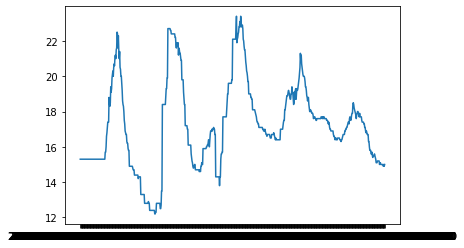

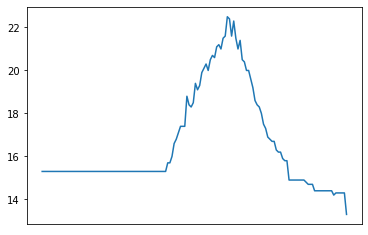

In [208]:
plt.plot(data["觀測資料時間"][0:720],data["溫度"][0:720])
plt.show()
plt.plot(data["觀測資料時間"][0:6*24],data["溫度"][0:6*24])
plt.xticks([])
plt.show()

<h1>溫度預處理</h1>

In [209]:
feature_raw = data["溫度"][:-71]
target_raw = data["溫度"][71:]

feature = []
target = []

for i in feature_raw:           #經過此步驟才可使資料shape呈現(n,1)
    feature.append([i])
for i in target_raw:
    target.append([i])

In [210]:
length = 36
sampling_rate = 3
stride = 36
batch_size = 32

In [211]:
from tensorflow.keras.preprocessing.sequence import  TimeseriesGenerator

<h1>DNN</h1>

In [212]:
datagen_train = TimeseriesGenerator(feature, target, length=length, sampling_rate=sampling_rate, 
                                    stride=stride, batch_size=batch_size,
                                    start_index=0, end_index=100000)
datagen_val = TimeseriesGenerator(feature, target, length=length, sampling_rate=sampling_rate, 
                                    stride=stride, batch_size=batch_size,
                                    start_index=10001, end_index=130000)
datagen_test = TimeseriesGenerator(feature, target, stride=stride, length=length, sampling_rate=sampling_rate,
                                   start_index=130001, end_index=None, batch_size = batch_size)

In [213]:
print(datagen_train[0][0].shape)

(32, 12, 1)


In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten

In [215]:
DNN_model = Sequential()
DNN_model.add(Flatten(input_shape=(12,1)))
DNN_model.add(Dense(64, activation="relu"))
DNN_model.add(Dense(32, activation="relu"))
DNN_model.add(Dense(1))

DNN_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
DNN_model.summary()




Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [216]:
history = DNN_model.fit_generator(datagen_train, epochs=100, verbose=0, validation_data=datagen_val)

C:\Users\lucie\anaconda3\envs\tensorflowenv\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


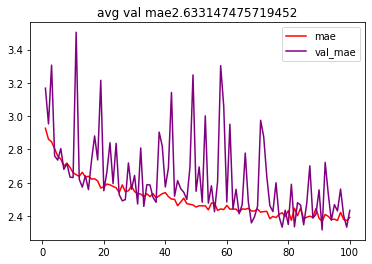

In [217]:
plt.plot([i for i in range(1,101)],history.history["mae"],color="red")
plt.plot([i for i in range(1,101)],history.history["val_mae"],color="purple")

val_mae_mean = np.mean(history.history["val_mae"])
plt.title(f"avg val mae{val_mae_mean}")
plt.legend(["mae","val_mae"])

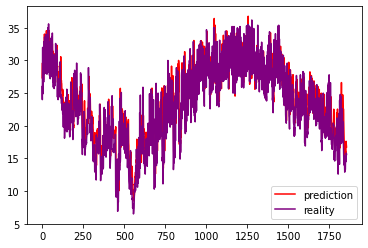

In [218]:
pred = DNN_model.predict(datagen_test)
plt.plot(pred,color="red")

reality = []
for data in datagen_test:
    for temp in data[1]:
        reality.append(temp)
plt.plot(reality,color="purple")
plt.legend(["prediction", "reality"])


<h1>RNN<h1>

In [219]:
from tensorflow.keras.layers import SimpleRNN

In [220]:

RNN_model = Sequential()

RNN_model.add(SimpleRNN(10, input_shape =(12,1)))
RNN_model.add(Dense(64, activation="relu"))
RNN_model.add(Dense(32, activation="relu"))
RNN_model.add(Dense(1))

RNN_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
RNN_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
dense_42 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 33        
Total params: 2,937
Trainable params: 2,937
Non-trainable params: 0
_________________________________________________________________


In [221]:
history = RNN_model.fit_generator(datagen_train, epochs=100, verbose=0, validation_data=datagen_val)

C:\Users\lucie\anaconda3\envs\tensorflowenv\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


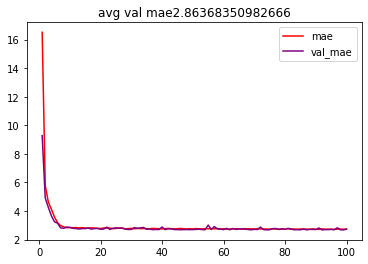

In [222]:
plt.plot([i for i in range(1,101)],history.history["mae"],color="red")
plt.plot([i for i in range(1,101)],history.history["val_mae"],color="purple")

val_mae_mean = np.mean(history.history["val_mae"])
plt.title(f"avg val mae{val_mae_mean}")
plt.legend(["mae","val_mae"])

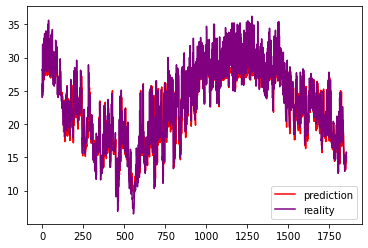

In [223]:
pred = RNN_model.predict(datagen_test)
plt.plot(pred,color="red")

reality = []
for data in datagen_test:
    for temp in data[1]:
        reality.append(temp)
plt.plot(reality,color="purple")
plt.legend(["prediction", "reality"])


<h1>Stateful RNN<h1>

In [224]:
def StatefulRNNGenerator(data, target, length, batch_size, stride, sampling_rate, start_index = 0, end_index = None):
    if end_index == None:
        end_index = len(data)-1
    data_len = (end_index - start_index + 1 - length) // stride
    new_batch_size = data_len // batch_size
    end_index = new_batch_size * batch_size * stride + length + start_index - 1
     
    
    data_gen = TimeseriesGenerator(data, target, sampling_rate = sampling_rate, stride = stride,length=length,
                                   start_index = start_index, end_index = end_index, batch_size = new_batch_size)
    new_data = []
    new_target = []
    
    for i in data_gen:
        new_data.append(i[0])
        new_target.append(i[1])
    
    new_data = np.array(new_data)
    new_target = np.array(new_target)
    
    new_data = new_data.transpose([1,0,2,3])
    new_target = new_target.transpose([1,0,2])
    
    new_datagen = []
    for i in range(len(new_data)):
        new_datagen.append((new_data[i], new_target[i] ))
    
    return new_datagen


In [225]:
StateRNN_datagen_train = StatefulRNNGenerator(data=feature, target = target, sampling_rate=sampling_rate, length=length,
                                     stride = stride, start_index=0, end_index=100000, batch_size=32)
StateRNN_datagen_val = StatefulRNNGenerator(data=feature, target = target, sampling_rate=sampling_rate, length=length,
                                     stride = stride, start_index=100001, end_index=130000, batch_size=32)
StateRNN_datagen_test = StatefulRNNGenerator(data=feature, target = target, sampling_rate=sampling_rate, length=length,
                                     stride = stride, start_index=130000, batch_size=32)

In [226]:
print(StateRNN_datagen_train[0][0].shape)
print(StateRNN_datagen_train[0][1].shape)

(32, 12, 1)
(32, 1)


In [227]:
StateRNN_model = Sequential()
StateRNN_model.add(SimpleRNN(10, stateful=True, batch_input_shape=(32,12,1)))
StateRNN_model.add(Dense(64, activation="relu"))
StateRNN_model.add(Dense(32, activation="relu"))
StateRNN_model.add(Dense(1))

StateRNN_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
StateRNN_model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (32, 10)                  120       
_________________________________________________________________
dense_45 (Dense)             (32, 64)                  704       
_________________________________________________________________
dense_46 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dense_47 (Dense)             (32, 1)                   33        
Total params: 2,937
Trainable params: 2,937
Non-trainable params: 0
_________________________________________________________________


In [228]:
from tensorflow.python.keras.utils.data_utils import iter_sequence_infinite as iter_inf

In [230]:
val_mae = []
mae = []
for i in range(100):
    history = StateRNN_model.fit(iter_inf(StateRNN_datagen_train), steps_per_epoch=len(StateRNN_datagen_train), 
                        validation_data=iter_inf(StateRNN_datagen_val), validation_steps=len(StateRNN_datagen_val),
                        epochs=1, verbose=0,shuffle=False)
    val_mae.append(history.history["val_mae"])
    mae.append(history.history["mae"])
    StateRNN_model.reset_states()

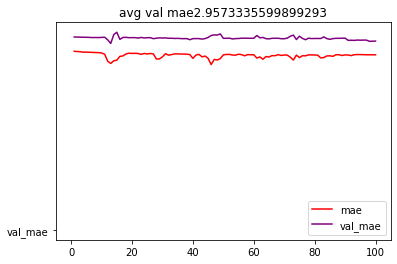

In [231]:
plt.plot([i for i in range(1,101)],mae,color="red")
plt.plot([i for i in range(1,101)],val_mae,["val_mae"],color="purple")

val_mae_mean = np.mean(val_mae)
plt.title(f"avg val mae{val_mae_mean}")
plt.legend(["mae","val_mae"])

C:\Users\lucie\anaconda3\envs\tensorflowenv\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


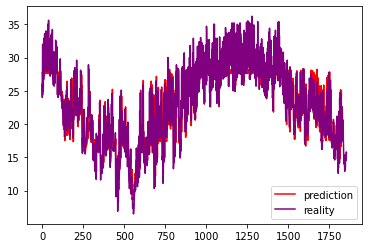

In [232]:
StateRNN_model.reset_states()
pred = StateRNN_model.predict_generator(iter_inf(StateRNN_datagen_test), steps=len(StateRNN_datagen_test))
pred = pred.reshape((len(pred)//32,32))
pred = pred.transpose(1, 0)
pred =  pred.reshape(-1,)                 
plt.plot(pred,color="red")

reality = []
for data in datagen_test:
    for temp in data[1]:
        reality.append(temp)
plt.plot(reality,color="purple")
plt.legend(["prediction", "reality"])


In [233]:
print("DNN", DNN_model.evaluate(datagen_test,steps=None,verbose=0))
print("RNN", RNN_model.evaluate(datagen_test,steps=None,verbose=0))

StateRNN_model.reset_states()
print("StateRNN", StateRNN_model.evaluate(iter_inf(StateRNN_datagen_test),steps = len(StateRNN_datagen_test),verbose=0))

DNN [9.128024101257324, 2.3658502101898193]
RNN [12.924016952514648, 2.787745475769043]
StateRNN [12.514128684997559, 2.755082607269287]
